<a href="https://colab.research.google.com/github/Khislatz/DS-Unit-2-Applied-Modeling/blob/master/Khislat_Zhuraeva_DS_Sprint_Challenge_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

# Applied Modeling Sprint Challenge: Predict Chicago food inspections 🍕

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to install packages in Colab:

In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:

- Confusion Matrix
- Permutation Importances
- Partial Dependence Plot, 1 feature isolation
- Partial Dependence Plot, 2 features interaction
- Shapley Values

_To earn a score of 3 for this part, make four of these visualization types._

## Part 1: Preprocessing

> You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

In [61]:
train.head(3)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0


In [62]:
train.dtypes

Inspection ID        int64
DBA Name            object
AKA Name            object
License #          float64
Facility Type       object
Risk                object
Address             object
City                object
State               object
Zip                float64
Inspection Date     object
Inspection Type     object
Violations          object
Latitude           float64
Longitude          float64
Location            object
Fail                 int64
dtype: object

In [0]:
# train['Inspection Date'] = pd.to_datetime(train['Inspection Date'], infer_datetime_format=True)
# train['Inspection Date']

def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()

    import datetime as dt
    X['Inspection Date'] = pd.to_datetime(X['Inspection Date'], infer_datetime_format=True)
    X['Inspection Date']=X['Inspection Date'].map(dt.datetime.toordinal)

    return X

In [0]:
train=wrangle(train)
test = wrangle(test)

In [0]:
target = 'Fail'
features = train.columns.drop([target])

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]


In [66]:
train.isnull().sum()

Inspection ID         0
DBA Name              0
AKA Name            623
License #             5
Facility Type       224
Risk                 12
Address               0
City                 53
State                10
Zip                  26
Inspection Date       0
Inspection Type       1
Violations         9655
Latitude            198
Longitude           198
Location            198
Fail                  0
dtype: int64

In [0]:
# train = train.fillna('Missing')
# train.head(2)

In [68]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer

pipeline = make_pipeline(
    ce.ordinal.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(max_depth=3)
)
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['DBA Name', 'AKA Name', 'Facility Type',
                                      'Risk', 'Address', 'City', 'State',
                                      'Inspection Type', 'Violations',
                                      'Location'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'DBA Name',
                                          'data_type': dtype('O'),
                                          'mapping': TOM YUM RICE & NOODLE, INC.                  1
FILLING STATION  & CONVENIENC...
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=3,
                                        m

In [69]:
from sklearn.metrics import roc_auc_score
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred_proba)

0.626787776983902

## Part 2: Modeling

> **Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.
>
> Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

In [70]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['Fail'], random_state=42)

train.shape, test.shape, val.shape

((41532, 17), (17306, 17), (10384, 17))

In [0]:
def wrangle1(X):
    """Wrangle train, validate, and test sets in the same way"""
    import datetime as dt
    X['Inspection Date'] = pd.to_datetime(X['Inspection Date'], infer_datetime_format=True)
    X['Inspection Date']=X['Inspection Date'].map(dt.datetime.toordinal)
    X.drop_duplicates(inplace=True)
    # cardinality = X.select_dtypes(exclude='number').nunique()
    # high_cardinality_feat = cardinality[cardinality > 30].index.tolist()
    # X = X.drop(columns=high_cardinality_feat)
    # Prevent SettingWithCopyWarning
    X = X.copy()
    return X

In [0]:
train = wrangle1(train)
val = wrangle1(val)
test = wrangle1(test)

In [0]:
target = 'Fail'
features = train.columns.drop([target])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]


In [74]:
X_train.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Violations', 'Latitude', 'Longitude', 'Location'],
      dtype='object')

In [75]:
pipeline.fit(X_train, y_train)
print(f'Val score (acc): {pipeline.score(X_val, y_val)}')

Val score (acc): 0.7423921417565486


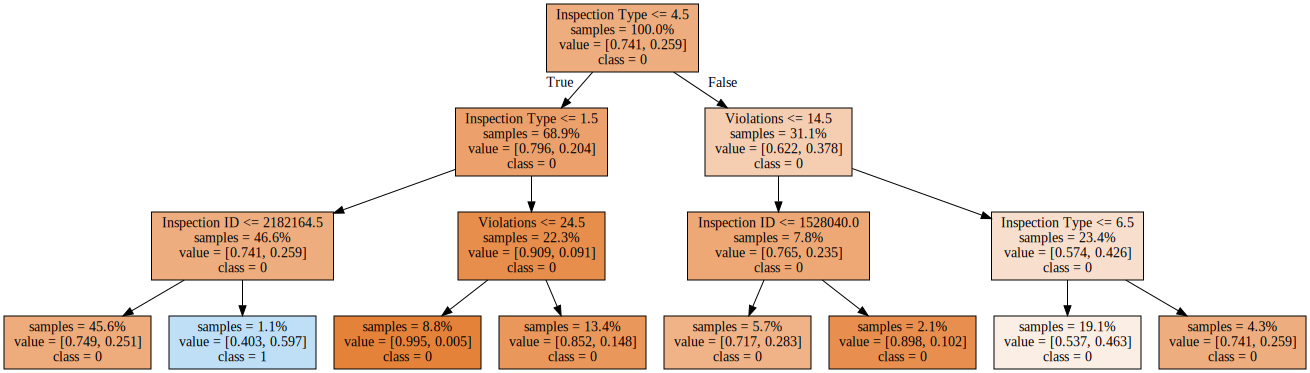

In [26]:
import graphviz
from sklearn.tree import export_graphviz

tree = pipeline.named_steps['decisiontreeclassifier']

dot_data = export_graphviz(
    tree, 
    out_file=None, 
    feature_names=X_train.columns, 
    class_names=y_train.unique().astype(str), 
    filled=True, 
    impurity=False,
    proportion=True
)

graphviz.Source(dot_data)

In [19]:
from sklearn.ensemble import RandomForestClassifier

rf = make_pipeline(
    ce.ordinal.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators =100, n_jobs=-1, random_state=42,)
)
rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['DBA Name', 'AKA Name', 'Facility Type',
                                      'Risk', 'Address', 'City', 'State',
                                      'Inspection Type', 'Violations',
                                      'Location'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'DBA Name',
                                          'data_type': dtype('O'),
                                          'mapping': CHANG'S ORIENTAL EXPRESS INC        1
B&B ICE CREAM AND CANDY             2
TH...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_le

In [20]:
print(f'Val score (acc): {rf.score(X_val, y_val)}')

Val score (acc): 0.7368066255778121


In [21]:
print(f'Test score (acc): {rf.score(X_test, y_test)}')

Test score (acc): 0.7382988558881313


In [50]:
from sklearn.metrics import roc_auc_score
y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_proba)

0.668391648241821

In [23]:
from sklearn.metrics import roc_auc_score
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred_proba)

0.6267859657280791

## Part 3: Visualization

> Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:
>
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

In [24]:
rf.named_steps['randomforestclassifier'].feature_importances_

array([1.48804545e-01, 7.07022701e-02, 7.01194696e-02, 1.02687507e-01,
       2.62131589e-02, 1.46847316e-02, 6.74149662e-02, 9.99100169e-04,
       2.15907070e-05, 5.23392788e-02, 0.00000000e+00, 7.77130702e-02,
       1.27418730e-01, 8.69747238e-02, 8.58818453e-02, 6.80250134e-02])

In [25]:
X_train.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Violations', 'Latitude', 'Longitude', 'Location'],
      dtype='object')

In [0]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [0]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['Latitude', 'Longitude']

interaction = pdp_interact(
    model=rf,
    dataset=X_val,
    model_features=X_val.columns,
    features=features)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


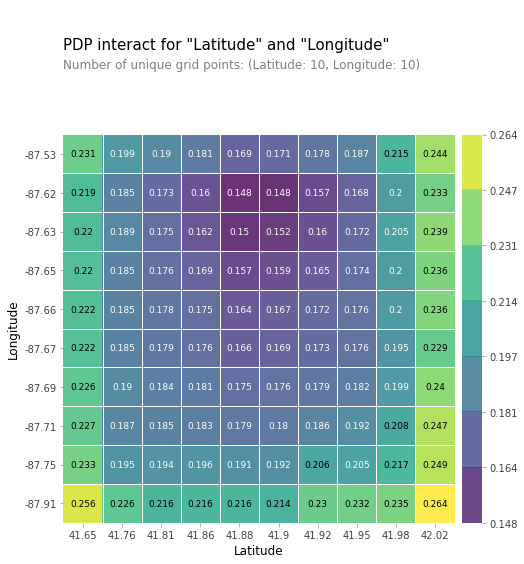

In [35]:
pdp_interact_plot(interaction, feature_names=features, plot_type='grid',);

In [28]:
X_train.dtypes

Inspection ID        int64
DBA Name            object
AKA Name            object
License #          float64
Facility Type       object
Risk                object
Address             object
City                object
State               object
Zip                float64
Inspection Date      int64
Inspection Type     object
Violations          object
Latitude           float64
Longitude          float64
Location            object
dtype: object

In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Inspection ID'

isolated = pdp_isolate(
    model=rf,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

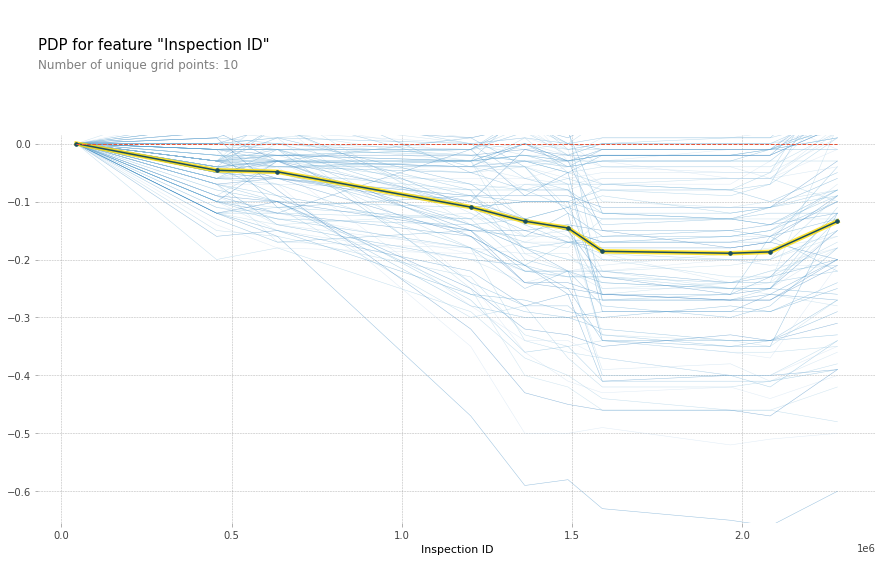

In [36]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=0.01);

In [77]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

param_distributions = { 
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestclassifier__n_estimators': randint(50, 500),
    'randomforestclassifier__bootstrap': [True, False],
    'randomforestclassifier__max_depth':[5, 10, 15, 20, None]

}
search = RandomizedSearchCV(
    rf, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=42
)

search.fit(X_train, y_train);

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.3min finished


In [89]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation accuracy', search.best_score_)
model = search.best_estimator_

Best hyperparameters {'randomforestclassifier__bootstrap': True, 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__n_estimators': 398, 'simpleimputer__strategy': 'mean'}
Cross-validation accuracy 0.7418616970047192


In [90]:
row = X_test.iloc[[1]]
row

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location
1,1575555,TAQUERIA LOS GALLOS INC,TAQUERIA LOS GALLOS,1044860.0,Restaurant,Risk 1 (High),4209-4211 W 26TH ST,CHICAGO,IL,60623.0,719163,Canvass,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",41.84407,-87.729807,"{'longitude': '-87.72980747367433', 'latitude'..."


In [91]:
y_test.iloc[[1]] 

1    0
Name: Fail, dtype: int64

In [92]:
model.predict(row)


array([0])

In [0]:
import shap

In [0]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)
shap_values

In [0]:
# shap_values = shap.TreeExplainer(model).shap_values(X_train)

In [0]:
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)